# Cascading Randomization Demo for Inception V3 (Guided BackProp)

Before running this notebook, makes sure you have the necessary dependencies installed first. (see the requirements.txt files for this).

For consistency of output, it is best if this notebook is run sequentially.

In [1]:
from __future__ import absolute_import, division, print_function

%matplotlib inline

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../')

import tensorflow as tf
import seaborn as sns
import saliency
import pickle
import PIL.Image
import json

from scipy.stats import spearmanr as spr
from scipy.stats import pearsonr
import pandas as pd
from skimage.measure import compare_ssim as ssim

import keras 
from matplotlib import gridspec
import seaborn as sns

import pandas as pd
from skimage import feature
slim=tf.contrib.slim

from src.inception_v3 import inception_v3_arg_scope
from src.inception_v3 import inception_v3

# some plotting defaults
%matplotlib inline
sns.set_style('whitegrid', {'axes.grid': False})
SSIZE=10
MSIZE=12
BSIZE=14
plt.rc('font', size=SSIZE)
plt.rc('axes', titlesize=MSIZE)
plt.rc('axes', labelsize=MSIZE)
plt.rc('xtick', labelsize=MSIZE)
plt.rc('ytick', labelsize=MSIZE)
plt.rc('legend', fontsize=MSIZE)
plt.rc('figure', titlesize=MSIZE)
plt.rcParams['font.family'] = "sans-serif"

Using TensorFlow backend.
W1108 16:28:09.849549 140420840093440 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W1108 16:28:09.856336 140420840093440 deprecation_wrapper.py:119] From ../src/inception_v3.py:39: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.



# Utility Functions

In [2]:
def abs_grayscale_norm(img):
    """Returns absolute value normalized image 2D."""
    assert isinstance(img, np.ndarray), "img should be a numpy array"
    
    shp = img.shape
    if len(shp)< 2:
        raise ValueError("Array should have 2 or 3 dims!")
    if len(shp)==2:
        img = np.absolute(img)
        img = img/float(img.max())
    else:
        img = saliency.VisualizeImageGrayscale(img)
    return img
def diverging_norm(img):
    """Returns image with positive and negative values."""
    assert isinstance(img, np.ndarray), "img should be a numpy array"
    
    shp = img.shape
    if len(shp)< 2:
        raise ValueError("Array should have 2 or 3 dims!")
    if len(shp)==2:
        imgmax = np.absolute(img).max()
        img = img/float(imgmax)
    else:
        img = saliency.VisualizeImageDiverging(img)
    return img

def plot_single_img(img,
                    ax=False,
                    norm=diverging_norm,
                    show_axis=False,
                    grayscale=False,
                    cmap='gray',
                    title='',
                    fig_size=(4,4)):
    plt.figure(figsize=fig_size)
    if norm:
        img = norm(img)
    if not show_axis:
        plt.axis('off')
    plt.imshow(img, cmap=cmap)
    if title:
        plt.title(title)
        
def LoadImage(file_path, resize=True, sztple=(299, 299)):
    img = PIL.Image.open(file_path).convert('RGB')
    if resize:
        img = img.resize(sztple, PIL.Image.ANTIALIAS)
    img = np.asarray(img)
    return img / 127.5 - 1.0

def ShowImage(im, title='', ax=None):
    if ax is None:
        plt.figure()
    plt.axis('off')
    im = ((im + 1) * 127.5).astype(np.uint8)
    plt.imshow(im)
    plt.title(title)
    
    
def normalize_image(x):
    x = np.array(x).astype(np.float32)
    x_min = x.min()
    x_max = x.max()
    x_norm = (x - x_min) / (x_max - x_min)
    return x_norm


def get_saliency_constructors(model_graph,
                              model_session,
                              logit_tensor,
                              input_tensor,
                              gradcam=False,
                              conv_layer_gradcam=None):
    """Initialize mask functions in saliency package.

    Args:
        model_graph: tf graph of the model.
        model_session: tf session with trained model loaded.
        logit_tensor: tensor corresponding to the model logit output.
        input_tensor: tensor coresponding to the input data.
        gradcam: boolean to indicate whether to include gradcam.
        conv_layer_gradcam: tensor corresponding to activations
                            from a conv layer, from the trained model.
                            Authors recommend last layer.
    Returns:
        saliency_constructor: dictionary (name of method, and value is
                              function to each saliency method.
        neuron_selector: tensor of specific output to explain.
    """

    assert (type(tf.Graph()) == type(model_graph)),\
        ("Model graph should be of type {}".format(type(tf.Graph())))

    if gradcam and conv_layer_gradcam is None:
        raise ValueError("If gradcam is True, then conv_layer_gradcam"
                         "is be provided.")
    with model_graph.as_default():
        with tf.name_scope("saliency"):
            neuron_selector = tf.placeholder(tf.int32)
            y_salient = logit_tensor[neuron_selector]
    gradient_saliency = saliency.GradientSaliency(model_graph,
                                                  model_session,
                                                  y_salient,
                                                  input_tensor)
    guided_backprop = saliency.GuidedBackprop(model_graph,
                                              model_session,
                                              y_salient,
                                              input_tensor)
    integrated_gradients = saliency.IntegratedGradients(model_graph,
                                                        model_session,
                                                        y_salient,
                                                        input_tensor)
    saliency_constructor = {'vng': gradient_saliency,
                            'gbp': guided_backprop,
                            'ig': integrated_gradients}
    if gradcam:
        gradcam = saliency.GradCam(model_graph,
                                   model_session,
                                   y_salient,
                                   input_tensor,
                                   conv_layer_gradcam)
        saliency_constructor['gc'] = gradcam
        
    return saliency_constructor, neuron_selector

class Inceptionv3_Wrapper(object):
    def __init__(self, checkpointpath, labelmetadatapath):
        tf.reset_default_graph()
        self.graph = tf.Graph()
        self.chkpntpath = checkpointpath
        self.labelmetadatapath = labelmetadatapath
        self.num_classes = 1001 # 0 is background or null class
        self.label_dict = {}
        
        if not tf.io.gfile.exists(self.chkpntpath):
            raise ValueError("There is no checkpoint at the input path")
        with self.graph.as_default():
            self.input_batch = tf.placeholder(tf.float32,
                                          shape=(None, 299, 299, 3))
            with slim.arg_scope(inception_v3_arg_scope()):
                _, self.end_points = inception_v3(
                  self.input_batch,
                  is_training=False,
                  num_classes=self.num_classes)
                self.session = tf.Session(graph=self.graph)
                self.saver = tf.train.Saver()
                self.saver.restore(self.session, self.chkpntpath)
                
            self.logits = self.graph.get_tensor_by_name(
                'InceptionV3/Logits/SpatialSqueeze:0')
            self.trainable_variables = tf.trainable_variables()
        
        if not tf.io.gfile.exists(self.labelmetadatapath):
            raise ValueError("There is no label file at the input path.")
        
        # process labels in appropriate dictionary
        with open(self.labelmetadatapath) as json_file:
            data = json.load(json_file)
            shift = 0
            if self.num_classes == 1001:
                self.label_dict = {0: ["background", "background"]}
                shift = 1
            for key in data:
                self.label_dict[int(key)+shift] = data[key] 
        
    def predict(self, batch):
        if not isinstance(batch, (np.ndarray)):
            raise ValueError("input should be a numpy array!")
        
        if len(batch.shape) < 4:
            raise ValueError(
              "Shape should be (nsamples, height, width, channels)")
        
        feed_dict = {self.input_batch: batch}
        logits = self.session.run(self.logits,
                                  feed_dict = feed_dict)
        return logits
    
    def reinitlayerlist(self, blocklist, independent=False):
        """Reinitialize Tensors with these names."""
        if independent:
            self.__init__()
        tensors = []
        for op in self.trainable_variables:
            for blockname in blocklist:
                if blockname in op.name:
                    tensors.append(op)
                    
        # now reinitialize
        with self.graph.as_default():
            to_ini = tf.initialize_variables(tensors)
            _ = self.session.run(to_ini)
        return True
        
    def indextoclsnames(self, arr, topk=5):
        """Given a numpy vector, get label names for topk."""
        names = []
        topk_indices = arr.argsort()[::-1][:topk]
        for val in topk_indices:
            names.append(self.label_dict[val][1])
        return names

In [3]:
cwd = os.getcwd()
imagenetlabeljsonpath = '../models/inceptionv3/imagenet_class_index.json'
chkpntpath = '../models/inceptionv3/inception_v3.ckpt'
chkpntpath = os.path.join(cwd, chkpntpath)
imagenetlabeljsonpath = os.path.join(cwd, imagenetlabeljsonpath)
if not os.path.exists(chkpntpath):
    raise ValueError("Checkpoint path does not exist!")
if not os.path.exists(imagenetlabeljsonpath):
    raise ValueError("Label json path does not exist!")

# Compute GBP masks for normal model

In [4]:
inception_model = Inceptionv3_Wrapper(chkpntpath, imagenetlabeljsonpath)
# assemble a list of these images
demo_image_path = '../data/demo_images/'
listfiles =  tf.io.gfile.listdir(demo_image_path)
demo_batch = []
for fl in listfiles:
    demo_batch.append(LoadImage(demo_image_path+fl, resize=True))
demo_batch = np.array(demo_batch)
print(demo_batch.shape)

W1108 16:28:10.003051 140420840093440 deprecation_wrapper.py:119] From ../src/inception_v3.py:528: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W1108 16:28:19.403882 140420840093440 deprecation.py:323] From /home/julius/virtualenvs/sanity_checks/lib/python3.5/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


(8, 299, 299, 3)


In [5]:
saliency_dict, n_selector = get_saliency_constructors(inception_model.graph,
                                                      inception_model.session,
                                                      inception_model.logits[0],
                                                      inception_model.input_batch,
                                                      gradcam=False,
                                                      conv_layer_gradcam="")

# these are the methods we will look at
saliency_methods = {'Guided\nBackProp': saliency_dict['gbp'].GetMask}
list_of_masks = []
for i, current_image in enumerate(demo_batch):
    print("On image {}".format(i))
    baseline = np.zeros(current_image.shape)
    imglogits = inception_model.session.run(
        [inception_model.logits],
        feed_dict={inception_model.input_batch: np.expand_dims(current_image, 0)})[0]
    
    prediction_class = imglogits.argmax() # this the output to explain.
    gen_feed_dict = {n_selector: prediction_class}
    
    # set up params for each saliency method
    saliency_params = {'Guided\nBackProp': {"feed_dict": gen_feed_dict}}    
    
    output_masks = {}
    for key in saliency_methods:
        # print("On {}".format(key))
        params = saliency_params[key]
        output_masks[key] = saliency_methods[key](current_image,**params)
    list_of_masks.append(output_masks)

W1108 16:28:22.064312 140420840093440 deprecation_wrapper.py:119] From /home/julius/virtualenvs/sanity_checks/lib/python3.5/site-packages/saliency/guided_backprop.py:49: The name tf.train.Saver is deprecated. Please use tf.compat.v1.train.Saver instead.

W1108 16:28:24.485110 140420840093440 deprecation_wrapper.py:119] From /home/julius/virtualenvs/sanity_checks/lib/python3.5/site-packages/saliency/guided_backprop.py:56: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



On image 0
On image 1
On image 2
On image 3
On image 4
On image 5
On image 6
On image 7


In [6]:
# We are now doing normalization of the different attributions
# normalize by absolute values
list_of_masks_abs_norm = []

# normalize but keep the signs
list_of_masks_no_abs_norm = []
list_of_masks_0_1_norm = []

for i, img_dict in enumerate(list_of_masks):
    new_dict_abs_norm = {}
    new_dict_no_abs_norm = {}
    new_dict_0_1_norm = {}
    for key in img_dict:
        mask = img_dict[key]
        mask_abs_norm = abs_grayscale_norm(mask)
        mask_no_abs_norm = diverging_norm(mask)
        mask_0_1_norm = normalize_image(mask)
        new_dict_abs_norm[key] = mask_abs_norm
        new_dict_no_abs_norm[key] = mask_no_abs_norm
        new_dict_0_1_norm[key] =mask_0_1_norm
    list_of_masks_abs_norm.append(new_dict_abs_norm)
    list_of_masks_no_abs_norm.append(new_dict_no_abs_norm)
    list_of_masks_0_1_norm.append(new_dict_0_1_norm)

In [7]:
# format is [(input, mask1, mask2, etc)]
mask_order = ["Guided\nBackProp"]
master_mask_list_abs_norm = []
master_mask_list_no_abs_norm = []
for i, (img_dict_abs_norm, img_dict_no_abs_norm) in enumerate(zip(list_of_masks_abs_norm,
                                                                  list_of_masks_no_abs_norm)):
    # first append original image
    og_img = demo_batch[i]
    master_mask_list_abs_norm.append(og_img)
    master_mask_list_no_abs_norm.append(og_img)
    
    # loop through dicts to append each mask type
    for mask_type in mask_order:
        master_mask_list_abs_norm.append(img_dict_abs_norm[mask_type])
        master_mask_list_no_abs_norm.append(img_dict_no_abs_norm[mask_type])

# Visualize Masks

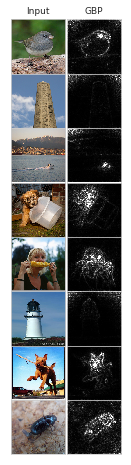

In [8]:
ncols = len(list_of_masks_abs_norm[i]) + 1
nrows = len(list_of_masks_abs_norm)

fig = plt.figure(figsize=(2,8))
gs = gridspec.GridSpec(nrows, ncols,
                       wspace=0.0, hspace=0.0)
cmap='gray'
count = 0
titles = ["Input", "GBP"]
for i in range(nrows):
    for j in range(ncols):
        ax = plt.subplot(gs[i, j])
        if (count==0) or (count%2==0):
            img = ((master_mask_list_abs_norm[count] + 1) * 127.5).astype(np.uint8)
            ax.imshow(img)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
        else:
            ax.imshow(master_mask_list_abs_norm[count],
                      vmin=0.0,
                      vmax=1.0,
                      cmap=cmap)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            
        # add labels
        if count <= 1:
            ax.set_title(titles[count], fontsize=9)
        count +=1
plt.show()

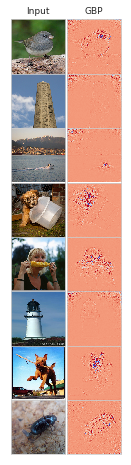

In [9]:
ncols = len(list_of_masks_no_abs_norm[i]) + 1
nrows = len(list_of_masks_no_abs_norm)

fig = plt.figure(figsize=(2,8))
gs = gridspec.GridSpec(nrows, ncols,
                       wspace=0.0, hspace=0.0)
cmap='coolwarm'
count = 0
titles = ["Input", "GBP"]
for i in range(nrows):
    for j in range(ncols):
        ax = plt.subplot(gs[i, j])
        if (count==0) or (count%2==0):
            img = ((master_mask_list_no_abs_norm[count] + 1) * 127.5).astype(np.uint8)
            ax.imshow(img)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
        else:
            ax.imshow(master_mask_list_no_abs_norm[count],
                      vmin=-1.0,
                      vmax=1.0,
                      cmap=cmap)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            
        # add labels
        if count <= 1:
            ax.set_title(titles[count], fontsize=9)
        count +=1
plt.show()

# Conduct Cascading Randomization

In [10]:
master_cascading_randomization_dictionary = {} # key will be layer name.
layer_randomization_order = ['InceptionV3/Logits', 'InceptionV3/Mixed_7c',
                             'InceptionV3/Mixed_7b', 'InceptionV3/Mixed_7a',
                             'InceptionV3/Mixed_6e', 'InceptionV3/Mixed_6d',
                             'InceptionV3/Mixed_6c', 'InceptionV3/Mixed_6b', 
                             'InceptionV3/Mixed_6a', 'InceptionV3/Mixed_5d',
                             'InceptionV3/Mixed_5c', 'InceptionV3/Mixed_5b',
                             'InceptionV3/Conv2d_4a_3x3', 'InceptionV3/Conv2d_3b_1x1',
                             'InceptionV3/Conv2d_2b_3x3', 'InceptionV3/Conv2d_2a_3x3',
                             'InceptionV3/Conv2d_1a_3x3']
# begin randomization
for i, layer_name in enumerate(layer_randomization_order):
    print("Randomized up to on layer {}".format(layer_name))
    
    # load model with normal weights. 
    inception_model = Inceptionv3_Wrapper(chkpntpath, imagenetlabeljsonpath)
    
    # list of layers to randomize
    layer_list = layer_randomization_order[:i+1]
    
    # randomize all trainable ops up to that layer
    inception_model.reinitlayerlist(layer_list)
    
    saliency_dict, n_selector = get_saliency_constructors(inception_model.graph,
                                                      inception_model.session,
                                                      inception_model.logits[0],
                                                      inception_model.input_batch,
                                                      gradcam=False,
                                                      conv_layer_gradcam="")
    
    # these are the methods we will look at
    saliency_methods = {'Guided\nBackProp': saliency_dict['gbp'].GetMask}
    
    # list to store collection of images
    list_of_random_mask_per_layer = []
    for j, current_image in enumerate(demo_batch):
        # print(j)
        imglogits = inception_model.session.run(
            [inception_model.logits],
            feed_dict={inception_model.input_batch: np.expand_dims(current_image, 0)})[0]

        prediction_class = imglogits.argmax() # this the output to explain.
        gen_feed_dict = {n_selector: prediction_class}

        # set up params for each saliency method
        saliency_params = {'Guided\nBackProp': {"feed_dict": gen_feed_dict}}    

        output_masks = {}
        for key in saliency_methods:
            # print("On {}".format(key))
            params = saliency_params[key]
            output_masks[key] = saliency_methods[key](current_image,**params)
        # compute some other methods
        # input-gradient and guided-gradcam
        list_of_random_mask_per_layer.append(output_masks)
        # now add the list of random masks to the dictionary
    master_cascading_randomization_dictionary[layer_name] = list_of_random_mask_per_layer

Randomized up to on layer InceptionV3/Logits


W1108 16:28:50.138014 140420840093440 deprecation.py:323] From /home/julius/virtualenvs/sanity_checks/lib/python3.5/site-packages/tensorflow/python/util/tf_should_use.py:193: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.


Randomized up to on layer InceptionV3/Mixed_7c
Randomized up to on layer InceptionV3/Mixed_7b
Randomized up to on layer InceptionV3/Mixed_7a
Randomized up to on layer InceptionV3/Mixed_6e
Randomized up to on layer InceptionV3/Mixed_6d
Randomized up to on layer InceptionV3/Mixed_6c
Randomized up to on layer InceptionV3/Mixed_6b
Randomized up to on layer InceptionV3/Mixed_6a
Randomized up to on layer InceptionV3/Mixed_5d
Randomized up to on layer InceptionV3/Mixed_5c
Randomized up to on layer InceptionV3/Mixed_5b
Randomized up to on layer InceptionV3/Conv2d_4a_3x3
Randomized up to on layer InceptionV3/Conv2d_3b_1x1
Randomized up to on layer InceptionV3/Conv2d_2b_3x3
Randomized up to on layer InceptionV3/Conv2d_2a_3x3
Randomized up to on layer InceptionV3/Conv2d_1a_3x3


In [11]:
master_cascading_randomization_dictionary_abs_norm = {}
master_cascading_randomization_dictionary_no_abs_norm = {}
master_cascading_randomization_dictionary_0_1_norm = {}

for layer in master_cascading_randomization_dictionary:
    mask_list_abs_norm = []
    mask_list_no_abs_norm = []
    mask_list_0_1_norm = []
    for i, mask_dict in enumerate(master_cascading_randomization_dictionary[layer]):
    # first append original image
        new_dict_abs_norm = {}
        new_dict_no_abs_norm = {}
        new_dict_0_1_norm = {}
        for key in mask_dict:
            mask = mask_dict[key]
            
            mask_abs_norm = abs_grayscale_norm(mask)
            mask_no_abs_norm = diverging_norm(mask)
            mask_0_1_norm = normalize_image(mask)
            
            new_dict_abs_norm[key] = mask_abs_norm
            new_dict_no_abs_norm[key] = mask_no_abs_norm
            new_dict_0_1_norm[key] = mask_0_1_norm
            
        mask_list_abs_norm.append(new_dict_abs_norm)
        mask_list_no_abs_norm.append(new_dict_no_abs_norm)
        mask_list_0_1_norm.append(new_dict_0_1_norm)
    master_cascading_randomization_dictionary_abs_norm[layer] = mask_list_abs_norm
    master_cascading_randomization_dictionary_no_abs_norm[layer] = mask_list_no_abs_norm
    master_cascading_randomization_dictionary_0_1_norm[layer] = mask_list_0_1_norm

In [12]:
for key in master_cascading_randomization_dictionary:
    assert len(master_cascading_randomization_dictionary[key])==len(master_cascading_randomization_dictionary_no_abs_norm[key])
    for i, item in enumerate(master_cascading_randomization_dictionary[key]):
        assert len(item)==len(master_cascading_randomization_dictionary_no_abs_norm[key][i])
for key in master_cascading_randomization_dictionary:
    assert len(master_cascading_randomization_dictionary[key])==len(master_cascading_randomization_dictionary_abs_norm[key])
    for i, item in enumerate(master_cascading_randomization_dictionary[key]):
        assert len(item)==len(master_cascading_randomization_dictionary_abs_norm[key][i])
for key in master_cascading_randomization_dictionary:
    assert len(master_cascading_randomization_dictionary[key])==len(master_cascading_randomization_dictionary_0_1_norm[key])
    for i, item in enumerate(master_cascading_randomization_dictionary[key]):
        assert len(item)==len(master_cascading_randomization_dictionary_0_1_norm[key][i])

In [13]:
cascading_master_plotting_list_abs_norm = []
cascading_master_plotting_list_no_abs_norm = []

# Order that we want to show the masks in.
mask_order = ["Guided\nBackProp"]

for index_input_to_plot, orig_img in enumerate(demo_batch):
    
    cascading_master_plotting_list_abs_norm.append(orig_img)
    cascading_master_plotting_list_no_abs_norm.append(orig_img)
    
    for method in mask_order:
        # first insert normal saliency method
        normal_mask_abs_norm = list_of_masks_abs_norm[index_input_to_plot][method]
        normal_mask_no_abs_norm = list_of_masks_no_abs_norm[index_input_to_plot][method]
        cascading_master_plotting_list_abs_norm.append(normal_mask_abs_norm)
        cascading_master_plotting_list_no_abs_norm.append(normal_mask_no_abs_norm)
        for layer in layer_randomization_order:
            mask_abs_norm =  master_cascading_randomization_dictionary_abs_norm[layer][index_input_to_plot][method]
            cascading_master_plotting_list_abs_norm.append(mask_abs_norm)

            mask_no_abs_norm =  master_cascading_randomization_dictionary_no_abs_norm[layer][index_input_to_plot][method]
            cascading_master_plotting_list_no_abs_norm.append(mask_no_abs_norm)

# Let's Plot

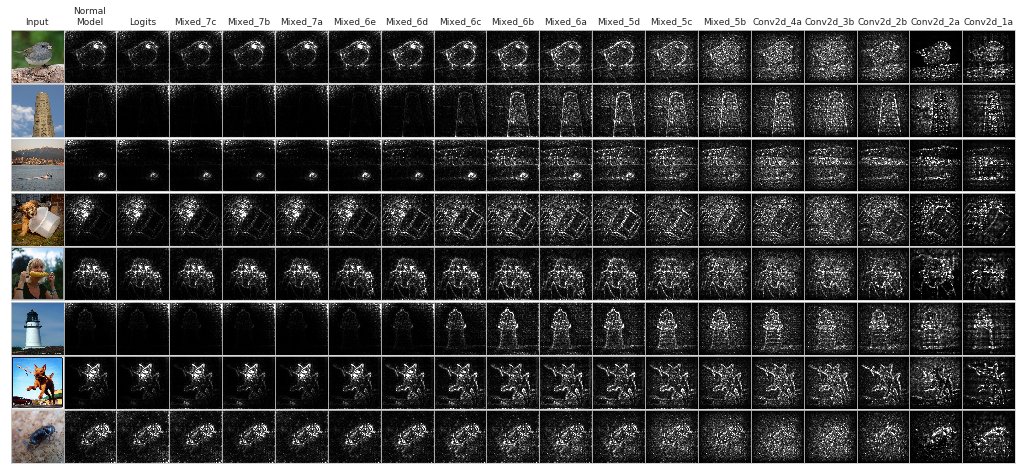

In [14]:
nrows = len(demo_batch)
ncols = int(len(cascading_master_plotting_list_abs_norm)/nrows)

fig = plt.figure(figsize=(18,8))
gs = gridspec.GridSpec(nrows, ncols,
                       wspace=0.0, hspace=0.0)
cmap='gray'
count = 0
titles=["Input", "Normal\nModel"]
for val in layer_randomization_order:
    tl = val.split("/")[1]
    if len(tl)>8:
        tl = tl[:9]
    titles.append(tl)
for i in range(nrows):
    for j in range(ncols):
        ax = plt.subplot(gs[i, j])
        if (count==0) or (count%19==0):
            img = ((cascading_master_plotting_list_abs_norm[count] + 1) * 127.5).astype(np.uint8)
            ax.imshow(img)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
        else:
            ax.imshow(cascading_master_plotting_list_abs_norm[count],
                      vmin=0.0,
                      vmax=1.0,
                      cmap=cmap)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            
        # add labels
        if count < 19:
            ax.set_title(titles[count], fontsize=9)
        count +=1
plt.show()

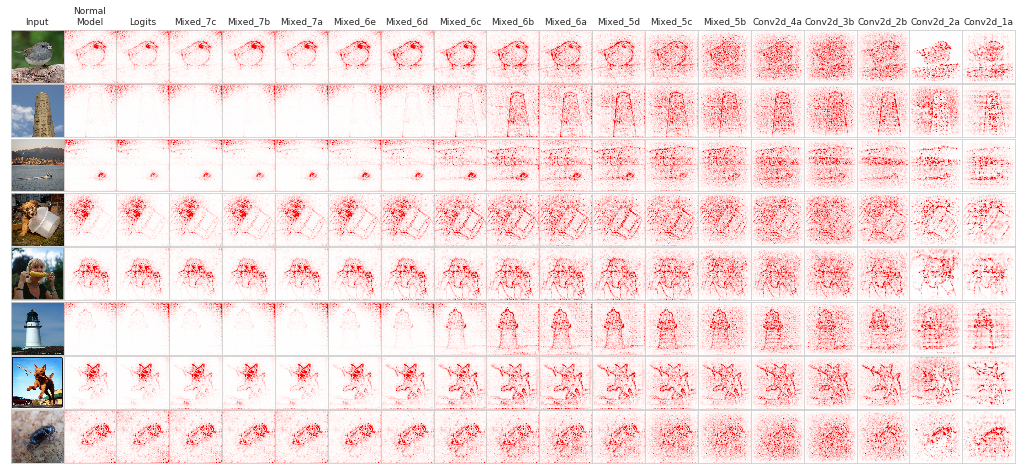

In [15]:
fig = plt.figure(figsize=(18,8))
gs = gridspec.GridSpec(nrows, ncols,
                       wspace=0.0, hspace=0.0)
cmap='bwr'
count = 0
for i in range(nrows):
    for j in range(ncols):
        ax = plt.subplot(gs[i, j])
        if (count==0) or (count%19==0):
            img = ((cascading_master_plotting_list_abs_norm[count] + 1) * 127.5).astype(np.uint8)
            ax.imshow(img)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
        else:
            ax.imshow(cascading_master_plotting_list_abs_norm[count],
                      vmin=-1.0,
                      vmax=1.0,
                      cmap=cmap)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            
        # add labels
        if count < 19:
            ax.set_title(titles[count], fontsize=9)
        count +=1
plt.show()

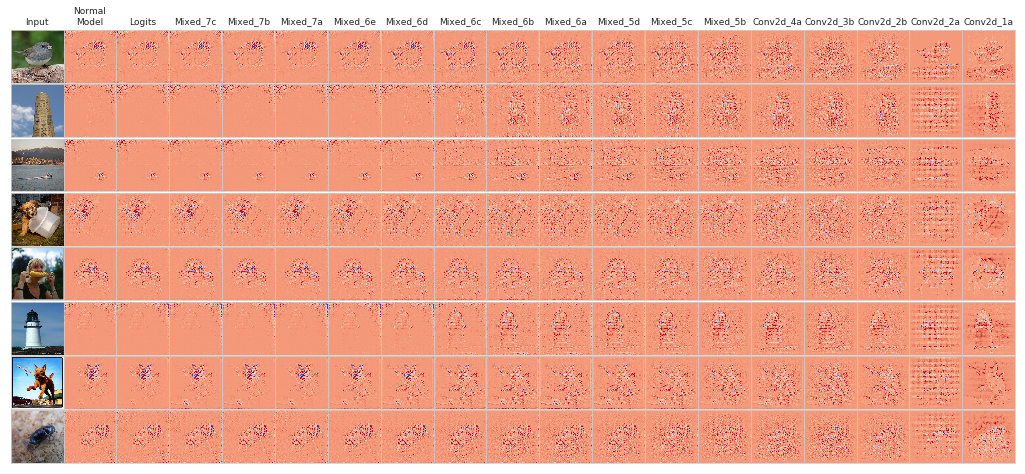

In [16]:
fig = plt.figure(figsize=(18,8))
gs = gridspec.GridSpec(nrows, ncols,
                       wspace=0.0, hspace=0.0)
cmap='coolwarm'
count = 0
for i in range(nrows):
    for j in range(ncols):
        ax = plt.subplot(gs[i, j])
        if (count==0) or (count%19==0):
            img = ((cascading_master_plotting_list_abs_norm[count] + 1) * 127.5).astype(np.uint8)
            ax.imshow(img)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
        else:
            ax.imshow(cascading_master_plotting_list_no_abs_norm[count],
                      vmin=-1.0,
                      vmax=1.0,
                      cmap=cmap)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            
        # add labels
        if count < 19:
            ax.set_title(titles[count], fontsize=9)
        count +=1
plt.show()

In [17]:
methods_list = list(master_cascading_randomization_dictionary_abs_norm['InceptionV3/Logits'][0].keys())

# dictionary to save all of the metrics.
rank_correlation_dictionary_abs_norm = {}
rank_correlation_dictionary_no_abs_norm = {}
ssim_dictionary_0_1_norm = {}
hog_dictionary_0_1_norm = {}

# initialize the dictionaries appropriately.
for layer in layer_randomization_order:
    rank_correlation_dictionary_abs_norm[layer] = {}
    rank_correlation_dictionary_no_abs_norm[layer] = {}
    ssim_dictionary_0_1_norm[layer] = {}
    hog_dictionary_0_1_norm[layer] = {}
    for method in methods_list:
        rank_correlation_dictionary_abs_norm[layer][method] = []
        rank_correlation_dictionary_no_abs_norm[layer][method] = []
        ssim_dictionary_0_1_norm[layer][method] = []
        hog_dictionary_0_1_norm[layer][method] = []
        
for layer in master_cascading_randomization_dictionary_abs_norm:
    for i, mask_dict in enumerate(master_cascading_randomization_dictionary_abs_norm[layer]):
        for method in methods_list:
            normal_mask_abs_norm = list_of_masks_abs_norm[i][method]
            normal_mask_no_abs_norm = list_of_masks_no_abs_norm[i][method]
            normal_mask_0_1_norm = list_of_masks_0_1_norm[i][method]
            
            
            rand_mask_abs_norm = mask_dict[method]
            rand_mask_no_abs_norm = master_cascading_randomization_dictionary_no_abs_norm[layer][i][method]
            rand_mask_0_1_norm = master_cascading_randomization_dictionary_0_1_norm[layer][i][method]
            
            # compute rank correlation
            rk_abs_abs_value_norm, _ = spr(normal_mask_abs_norm.flatten(), rand_mask_abs_norm.flatten())
            rk_no_abs_value_norm, _ = spr(normal_mask_no_abs_norm.flatten(), rand_mask_no_abs_norm.flatten())
            
            # compute ssim
            ss1 = ssim(normal_mask_0_1_norm, rand_mask_0_1_norm,
                       gaussian_weights=True, multichannel=True)
            
            # rank correlation between histogram of gradients
            normal_hog = feature.hog(normal_mask_0_1_norm,
                                     pixels_per_cell=(16, 16))
            rand_hog = feature.hog(rand_mask_0_1_norm,
                                   pixels_per_cell=(16, 16))
            rank_corr_hog = spr(normal_hog, rand_hog)[0]
            
            # collate all the values into their respective dictionaries.
            rank_correlation_dictionary_abs_norm[layer][method].append(rk_abs_abs_value_norm)
            rank_correlation_dictionary_no_abs_norm[layer][method].append(rk_no_abs_value_norm)
            ssim_dictionary_0_1_norm[layer][method].append(ss1)
            hog_dictionary_0_1_norm[layer][method].append(rank_corr_hog)

In [18]:
rk_mean_dictionary = {}
rk_std_dictionary = {}

for key in rank_correlation_dictionary_abs_norm:
    rk_mean_dictionary[key] = {}
    rk_std_dictionary[key] = {}
    for key2 in rank_correlation_dictionary_abs_norm[key]:
        rk_mean_dictionary[key][key2] = np.mean(rank_correlation_dictionary_abs_norm[key][key2])
        rk_std_dictionary[key][key2] = np.std(rank_correlation_dictionary_abs_norm[key][key2])
        
rk_mean_dictionary_no_abs = {}
rk_std_dictionary_no_abs = {}

for key in rank_correlation_dictionary_no_abs_norm:
    rk_mean_dictionary_no_abs[key] = {}
    rk_std_dictionary_no_abs[key] = {}
    for key2 in rank_correlation_dictionary_no_abs_norm[key]:
        rk_mean_dictionary_no_abs[key][key2] = np.mean(rank_correlation_dictionary_no_abs_norm[key][key2])
        rk_std_dictionary_no_abs[key][key2] = np.std(rank_correlation_dictionary_no_abs_norm[key][key2])

In [19]:
ssim_mean_dictionary = {}
ssim_std_dictionary = {}

for key in ssim_dictionary_0_1_norm:
    ssim_mean_dictionary[key] = {}
    ssim_std_dictionary[key] = {}
    for key2 in ssim_dictionary_0_1_norm[key]:
        ssim_mean_dictionary[key][key2] = np.mean(ssim_dictionary_0_1_norm[key][key2])
        ssim_std_dictionary[key][key2] = np.std(ssim_dictionary_0_1_norm[key][key2])
        
hog_mean_dictionary = {}
hog_std_dictionary = {}

for key in hog_dictionary_0_1_norm:
    hog_mean_dictionary[key] = {}
    hog_std_dictionary[key] = {}
    for key2 in hog_dictionary_0_1_norm[key]:
        hog_mean_dictionary[key][key2] = np.mean(hog_dictionary_0_1_norm[key][key2])
        hog_std_dictionary[key][key2] = np.std(hog_dictionary_0_1_norm[key][key2])

In [20]:
rk_df = pd.DataFrame(rk_mean_dictionary)
rk_df2 = pd.DataFrame(rk_std_dictionary)

# include no randomization
rk_df["Original"] = [1.0]*rk_df.shape[0]
rk_df2["Original"] = [0.0]*rk_df2.shape[0]

# switch order of the columns
layer_order=["Original"]
for val in layer_randomization_order:
    # tl = val.split("/")[1]
    # if len(tl)>8:
     #   tl = tl[:9]
    layer_order.append(val)
to_reverse = False # reverse the axis if desired
if to_reverse:
    layer_order = list(reversed(layer_order))
rk_df = rk_df.reindex(columns=layer_order)
rk_df2 = rk_df2.reindex(columns=layer_order)

new_layer_order = []
for val in layer_order:
    if "/" in val:
        val = val.split("/")[1]
        if len(tl)>8:
            val = val[:9]
    new_layer_order.append(val)
    
rk_df.columns = new_layer_order
rk_df2.columns = new_layer_order

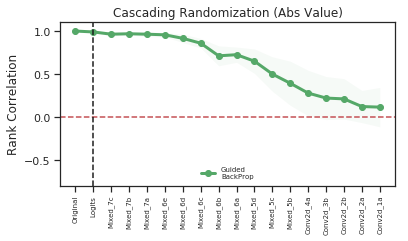

In [21]:
sns.set(style="ticks")
plt.figure(figsize=(6,3))
x = [i+1 for i in range(len(new_layer_order))]
plt.plot(x, rk_df.loc['Guided\nBackProp', : ].values,
         'go-', lw=3, label='Guided\nBackProp')
plt.fill_between(x, rk_df.loc['Guided\nBackProp', : ].values-rk_df2.loc['Guided\nBackProp', : ].values,
                 rk_df.loc['Guided\nBackProp', : ].values+rk_df2.loc['Guided\nBackProp', : ].values,
                 facecolor='g', alpha=0.05)
plt.xticks(x, new_layer_order)
plt.xticks(rotation=90, fontsize=7)
plt.axhline(y=0.0, color='r', linestyle='--')
plt.axvline(x=2.0, ymin=0.0, ymax=1.0, color='k', linestyle='--')
plt.ylim([-0.8, 1.1])
plt.ylabel("Rank Correlation")
plt.title("Cascading Randomization (Abs Value)")
plt.legend(loc=8, ncol=2, fontsize=7, frameon=False)
plt.tick_params(axis='x', which='both', top='off')
plt.show()

In [22]:
rk_df_no_abs = pd.DataFrame(rk_mean_dictionary_no_abs)
rk_df2_no_abs = pd.DataFrame(rk_std_dictionary_no_abs)

# include no randomization
rk_df_no_abs["Original"] = [1.0]*rk_df_no_abs.shape[0]
rk_df2_no_abs["Original"] = [0.0]*rk_df2_no_abs.shape[0]

# switch order of the columns
layer_order=["Original"]
for val in layer_randomization_order:
    layer_order.append(val)
to_reverse = False # reverse the axis if desired
if to_reverse:
    layer_order = list(reversed(layer_order))
rk_df_no_abs = rk_df_no_abs.reindex(columns=layer_order)
rk_df2_no_abs = rk_df2_no_abs.reindex(columns=layer_order)

rk_df_no_abs.columns = new_layer_order
rk_df2_no_abs.columns = new_layer_order

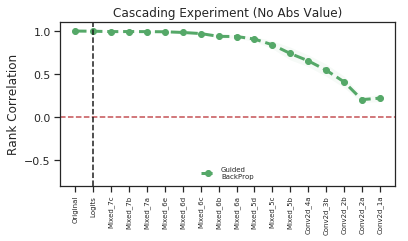

In [23]:
sns.set(style="ticks")
plt.figure(figsize=(6,3))
x = [i+1 for i in range(len(new_layer_order))]


plt.plot(x, rk_df_no_abs.loc['Guided\nBackProp', : ].values,
         'go-', lw=3, linestyle='--', label='Guided\nBackProp')
plt.fill_between(x, rk_df_no_abs.loc['Guided\nBackProp', : ].values-rk_df2_no_abs.loc['Guided\nBackProp', : ].values,
                 rk_df_no_abs.loc['Guided\nBackProp', : ].values+rk_df2_no_abs.loc['Guided\nBackProp', : ].values,
                 facecolor='g', alpha=0.05)

plt.xticks(x, new_layer_order)
plt.xticks(rotation=90, fontsize=7)
plt.axhline(y=0.0, color='r', linestyle='--')
plt.axvline(x=2.0, ymin=0.0, ymax=1.0, color='k', linestyle='--')
plt.ylim([-0.8, 1.1])
plt.ylabel("Rank Correlation")
plt.title("Cascading Experiment (No Abs Value)")
plt.legend(loc=8, ncol=2, fontsize=7, frameon=False)
plt.tick_params(axis='x', which='both', top='off')
plt.show()

In [24]:
ssim = pd.DataFrame(ssim_mean_dictionary)
ssim2 = pd.DataFrame(ssim_std_dictionary)

# include no randomization
ssim["Original"] = [1.0]*ssim.shape[0]
ssim2["Original"] = [0.0]*ssim2.shape[0]

# switch order of the columns
layer_order=["Original"]
for val in layer_randomization_order:
    layer_order.append(val)
to_reverse = False # reverse the axis if desired
if to_reverse:
    layer_order = list(reversed(layer_order))
ssim = ssim.reindex(columns=layer_order)
ssim2 = ssim2.reindex(columns=layer_order)
    
ssim.columns = new_layer_order
ssim2.columns = new_layer_order

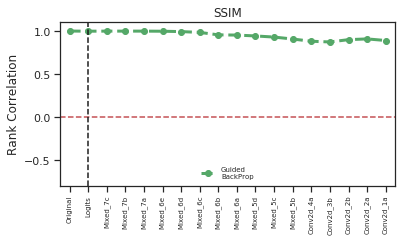

In [25]:
sns.set(style="ticks")
plt.figure(figsize=(6,3))
x = [i+1 for i in range(len(new_layer_order))]

plt.plot(x, ssim.loc['Guided\nBackProp', : ].values,
         'go-', lw=3, linestyle='--', label='Guided\nBackProp')
plt.fill_between(x, ssim.loc['Guided\nBackProp', : ].values-ssim2.loc['Guided\nBackProp', : ].values,
                 ssim.loc['Guided\nBackProp', : ].values+ssim2.loc['Guided\nBackProp', : ].values,
                 facecolor='g', alpha=0.01)

plt.xticks(x, new_layer_order)
plt.xticks(rotation=90, fontsize=7)
plt.axhline(y=0.0, color='r', linestyle='--')
plt.axvline(x=2.0, ymin=0.0, ymax=1.0, color='k', linestyle='--')
plt.ylim([-0.8, 1.1])
plt.xlim([0.5, 18.5])
plt.ylabel("Rank Correlation")
plt.title("SSIM")
plt.legend(loc=8, ncol=2, fontsize=7, frameon=False)
plt.tick_params(axis='x', which='both', top='off')
plt.show()

In [26]:
rkhog = pd.DataFrame(hog_mean_dictionary)
rkhog2 = pd.DataFrame(hog_std_dictionary)

# include no randomization
rkhog["Original"] = [1.0]*rk_df.shape[0]
rkhog2["Original"] = [0.0]*rk_df2.shape[0]

# switch order of the columns
layer_order=["Original"]
for val in layer_randomization_order:
    layer_order.append(val)
to_reverse = False # reverse the axis if desired
if to_reverse:
    layer_order = list(reversed(layer_order))
rkhog = rkhog.reindex(columns=layer_order)
rkhog2 = rkhog2.reindex(columns=layer_order)
    
rkhog.columns = new_layer_order
rkhog2.columns = new_layer_order

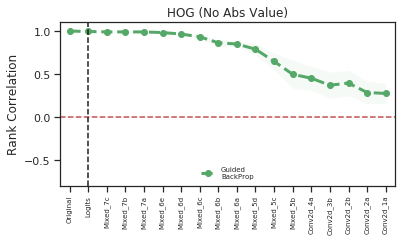

In [27]:
sns.set(style="ticks")
plt.figure(figsize=(6,3))
plt.plot(x, rkhog.loc['Guided\nBackProp', : ].values,
         'go-', lw=3, linestyle='--', label='Guided\nBackProp')
plt.fill_between(x, rkhog.loc['Guided\nBackProp', : ].values-rkhog2.loc['Guided\nBackProp', : ].values,
                 rkhog.loc['Guided\nBackProp', : ].values+rkhog2.loc['Guided\nBackProp', : ].values,
                 facecolor='g', alpha=0.05)

plt.xticks(x, new_layer_order)
plt.xticks(rotation=90, fontsize=7)
plt.axhline(y=0.0, color='r', linestyle='--')
plt.axvline(x=2.0, ymin=0.0, ymax=1.0, color='k', linestyle='--')
plt.ylim([-0.8, 1.1])
plt.xlim([0.5, 18.5])
plt.ylabel("Rank Correlation")
plt.title("HOG (No Abs Value)")
plt.legend(loc=8, ncol=2, fontsize=7, frameon=False)
plt.tick_params(axis='x', which='both', top='off')
plt.show()